#### Exercise 3.1

No. PLA will keep updating if the data is not linearly separable.

#### Exercise 3.2 TODO


In [53]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import math
from sklearn.preprocessing import normalize
from functools import partial

%matplotlib inline


def pocket_algo(points, dim, max_it=100, eta = 1, 
                randomized =False, print_out = True, 
                test_points=None):
    w = np.zeros(dim+1)
    xs, ys = points[:,:dim+1], points[:,dim+1]
    if test_points is not None:
        test_xs, test_ys = test_points[:,:dim+1], test_points[:,dim+1]
    num_points = points.shape[0]
    sample_err = math.inf
    w_ts, what_ts = np.zeros(max_it), np.zeros(max_it)
    test_w_ts, test_what_ts = np.zeros(max_it), np.zeros(max_it)
    wh = w #PLA w
    for it in range(max_it):
        idxs = np.arange(num_points)
        if randomized:
            idxs = np.random.choice(np.arange(num_points), num_points, replace=False)
            
        for idx in idxs:
            x, y = xs[idx], ys[idx]
            st = np.dot(wh.T, x)
            prod = st*y
            if prod <= 0:
                wh = wh + eta *y*x
                break
                
        in_sample_err = calc_error(wh, xs, ys)
        test_sample_err = calc_error(wh, test_xs, test_ys)
        w_ts[it] = in_sample_err
        test_w_ts[it] = test_sample_err
        if in_sample_err < sample_err:
            w = wh
            sample_err = in_sample_err
            what_ts[it] = sample_err
            test_what_ts[it] = test_sample_err

    w = w/w[-1]
    if print_out:
        print('final Error Rate: ', sample_err)
        print('final normalized w:', w)    
    return w, w_ts, what_ts, test_w_ts, test_what_ts
    
def calc_error(w, xs, ys):
    c = 0
    for x, y in zip(xs, ys):
        prod = np.dot(w.T, x)*y
        if prod < 0:
            c +=1
    return c/len(ys)

def generate_two_classes(N, dim, true_func, rn_func):
    cls1, cls2 = [], []
    while True:
        rn = rn_func(1, dim).flatten()
        if true_func(rn) > 0 and len(cls1) < N:
            cls1.append(rn)
        elif true_func(rn) < 0 and len(cls2) < N:
            cls2.append(rn)
        if len(cls1) == N and len(cls2) == N:
            break
    return np.asarray(cls1), np.asarray(cls2)   

def generate_random_numbers01(N, dim, num_grid_points):
    random_ints = np.random.randint(num_grid_points, size=(N, dim))
    init_lb = 0
    return (random_ints - init_lb)/(num_grid_points - 1 - init_lb)

def generate_random_numbers(N, dim, num_grid_points, lb, ub):
    zero_to_one_points = generate_random_numbers01(N, dim, num_grid_points)
    res = lb + (ub - lb)*zero_to_one_points
    return res

def generate_random_coeffs(dim):
    rn = generate_random_numbers(1, dim, 1000, -10, 10)
    return rn

def true_f(x, coeffs):
    return coeffs.flatten()[0] + np.dot(coeffs.flatten()[1:], x.flatten())

def generate_df(N, dim,true_func, rn_func):
    cls1, cls2 = generate_two_classes(N/2, dim, true_func, rn_func)
    cols = ['x' + str(i) for i in range(1, dim+1)]
    df1 = pd.DataFrame(cls1, columns=cols)
    df1['y'] = 1
    df2 = pd.DataFrame(cls2, columns=cols)
    df2['y'] = -1
    df = pd.concat([df1, df2])
    df['x0'] = 1
    df = df[['x0'] + cols + ['y']]
    return df

def get_true_random_funcs(N, dim, num_grid_points, lb, ub, coeff_lb, coeff_ub):
    rns = generate_random_numbers(N, dim, num_grid_points, lb, ub)
    rn_func = partial(generate_random_numbers, num_grid_points = num_grid_points, lb = lb, ub = ub)
    coeffs = generate_random_numbers(1, dim+1, num_grid_points, coeff_lb, coeff_ub)
    norm_coeffs = coeffs.flatten()/coeffs.flatten()[-1]
    true_func = partial(true_f, coeffs = norm_coeffs)
    return true_func, rn_func, norm_coeffs

def gen_random_2class_data(N, dim,  num_grid_points, lb, ub, coeff_lb, coeff_ub):
    true_func, rn_func, norm_coeffs = get_true_random_funcs(N, dim, num_grid_points,
                                                            lb, ub, coeff_lb, coeff_ub)
    df = generate_df(N, dim, true_func, rn_func)
    return df, norm_coeffs

def plot_data(x1, df, norm_coeffs, norm_g, lb, ub):
        figsize = plt.figaspect(1)
        f, ax = plt.subplots(1, 1, figsize=figsize)
        cls1_df = df.loc[df['y']==1]
        cls2_df = df.loc[df['y']==-1]
        line = ax.plot(x1, -(norm_coeffs[0]+norm_coeffs[1]*x1), label='True Function')
        pluses = ax.scatter(cls1_df[['x1']].values, cls1_df[['x2']].values, marker='+', c= 'r', label='+1 labels')
        minuses = ax.scatter(cls2_df[['x1']].values, cls2_df[['x2']].values, marker=r'$-$', c= 'b', label='-1 labels')
        if norm_g:
            hypothesis = ax.plot(x1, -(norm_g[0]+norm_g[1]*x1), c = 'r', label='Final Hypothesis')

        ax.set_ylabel(r"$x_2$", fontsize=11)
        ax.set_xlabel(r"$x_1$", fontsize=11)
        ax.set_title('Data set size = %s'%N, fontsize=9)
        ax.axis('tight')
        legend_x = 2.0
        legend_y = 0.5
        ax.legend(['True Function', 'Final Hypothesis', 
                   '+1 labels', '-1 labels', ], 
                  loc='center right', bbox_to_anchor=(legend_x, legend_y))
        #ax.legend(handles=[pluses, minuses], fontsize=9)
        ax.set_ylim(bottom=lb, top=ub)
        plt.show()
        
def run_perceptron_experiment(N, dim, lb, ub, num_grid_points,
                             coeff_lb, coeff_ub, eta, maxit, use_adaline=False, randomize=False,
                             show_plot=True, test_N = 10000):
    
    rns = generate_random_numbers(N, dim, num_grid_points, lb, ub)
    rn_func = partial(generate_random_numbers, num_grid_points = num_grid_points, lb = lb, ub = ub)
    coeffs = generate_random_numbers(1, dim+1, num_grid_points, coeff_lb, coeff_ub)
    norm_coeffs = coeffs.flatten()/coeffs.flatten()[-1]
    true_func = partial(true_f, coeffs = norm_coeffs)
    
    df = generate_df(N, dim, true_func, rn_func)
    test_df = generate_df(test_N, dim, true_func, rn_func)
    
    
    norm_g, num_its = perceptron(df.values, dim, maxit, use_adaline, 
                                 eta, randomize, show_plot)
    
    if show_plot:
        print('True coeffs: ', norm_coeffs)
        plot_data(x1, df, norm_coeffs, norm_g, lb, ub)
    return num_its, norm_g, test_df

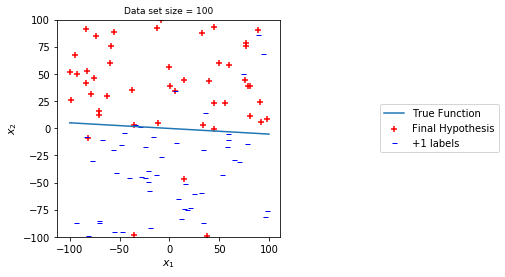

final Error Rate:  0.09
final normalized w: [-0.09564593  0.05645933  1.        ]
final Error Rate:  0.09
final normalized w: [-0.07864918  0.0695082   1.        ]
final Error Rate:  0.09
final normalized w: [0.01094143 0.07279693 1.        ]
final Error Rate:  0.09
final normalized w: [-0.358849    0.05807814  1.        ]
final Error Rate:  0.09
final normalized w: [-0.08233867  0.05995423  1.        ]
final Error Rate:  0.09
final normalized w: [0.00989114 0.07273627 1.        ]
final Error Rate:  0.09
final normalized w: [0.0998945  0.06940589 1.        ]
final Error Rate:  0.09
final normalized w: [-0.0973539   0.07142857  1.        ]
final Error Rate:  0.09
final normalized w: [0.08175869 0.07157464 1.        ]
final Error Rate:  0.09
final normalized w: [0.04457079 0.07580825 1.        ]
final Error Rate:  0.09
final normalized w: [0.10947426 0.07338445 1.        ]
final Error Rate:  0.09
final normalized w: [-0.13151316  0.06578947  1.        ]
final Error Rate:  0.09
final norm

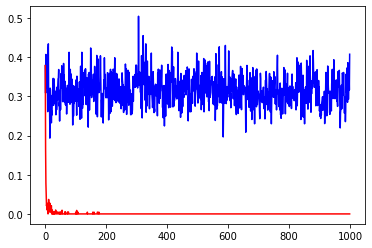

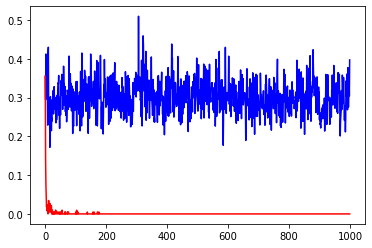

In [54]:
#### Exercise 3.2

lb, ub = -100, 100
N, dim = 100, 2 
num_grid_points = 2000
coeff_lb, coeff_ub = -10, 10
eta = 1
maxit = 1000
test_N = 1000

randomized, print_out = True, True
x1 = np.arange(lb, ub, 0.01)
#df, norm_coeffs = gen_random_2class_data(N, dim, num_grid_points, lb, ub, coeff_lb, coeff_ub)
true_func, rn_func, norm_coeffs = get_true_random_funcs(N, dim, num_grid_points,
                                           lb, ub, coeff_lb, coeff_ub)
df = generate_df(N, dim, true_func, rn_func)
test_df = generate_df(test_N, dim, true_func, rn_func)

flips = np.random.randint(N, size=(int(N/10), 1))
df.iloc[flips.flatten(), -1] = -df.iloc[flips.flatten(), ]['y']
plot_data(x1, df, norm_coeffs, None, lb, ub)

flips = np.random.randint(test_N, size=(int(test_N/10), 1))
test_df.iloc[flips.flatten(), -1] = -test_df.iloc[flips.flatten(), ]['y']

avg_w_ts, avg_what_ts = np.zeros(maxit), np.zeros(maxit)
avg_test_w_ts, avg_test_what_ts = np.zeros(maxit), np.zeros(maxit)
K = 20
for it in range(K):
    w, w_ts, what_ts, test_w_ts, test_what_ts = pocket_algo(df.values, dim, 
                                                                maxit,eta, randomized, 
                                                                print_out, test_df.values)
    
    #print(w_ts.shape, what_ts.shape, test_w_ts.shape, test_what_ts.shape)
    avg_w_ts += w_ts
    avg_what_ts += what_ts
    avg_test_w_ts += test_w_ts
    avg_test_what_ts += test_what_ts
    
plt.plot(np.arange(len(avg_w_ts)), avg_w_ts/K, 'b', label='Average E(w)')
plt.plot(np.arange(len(avg_what_ts)), avg_what_ts/K, 'r', label='Average E(\hat(W))')
plt.show()

plt.plot(np.arange(len(avg_test_w_ts)), avg_test_w_ts/K, 'b', label='Test: Average E(w)')
plt.plot(np.arange(len(avg_test_what_ts)), avg_test_what_ts/K, 'r', label='Test: Average E(\hat(W))')


plt.show()


#### Exercise 3.3

1. (a) $H$ is symmetric.

\begin{align}
H^T &= \left(X(X^TX)^{-1}X^T\right)^T\\
&= X(X^TX)^{-T}X^T\\
&= X(X^TX)^{-1}X^T\\
&= H\\
\end{align}

1. (b) We show that $H^2=H$ first.

\begin{align}
H^2 &= \left(X(X^TX)^{-1}X^T\right)\left(X(X^TX)^{-1}X^T\right)\\
&= X(X^TX)^{-1}(X^TX)(X^TX)^{-1}X^T\\
&= X(X^TX)^{-1}X^T\\
&= H\\
\end{align}

Apply the above relationship repeatedly for $H^K$ we see that $H^K = H$.

1. (c) First show $(I-H)^2=I-H$.

\begin{align}
(I-H)^2 &= (I-H)(I-H)\\
&= II - IH -HI + H^2\\
&= I - 2H + H^2\\
&= I-2H + H\\
&= I-H\\
\end{align}

Apply above relationship repeatedly for $(I-H)^K$, we have $(I-H)^K = I-H$.

1. (d) Let $A=X(X^TX)^{-1}$, $B=X^T$, apply the property $\text{trace}(AB)=\text{trace}(BA)$, we have

\begin{align}
\text{trace}(H) &= \text{trace}\left(X(X^TX)^{-1}X^T\right)\\
&= \text{trace}\left(AB\right)\\
&= \text{trace}\left(BA\right)\\
&=\text{trace}\left(X^TX(X^TX)^{-1}\right)\\
&=\text{trace}\left(I\right)\\
&= d+1\\
\end{align}

where the identity matrix $I$ is of size $d+1$.

#### Exercise 3.4

1. (a) We have $y = Xw^{*}+\epsilon$, take this into the expression for $\hat{y}$, we have

\begin{align}
\hat{y} &= Hy\\
&= H(Xw^{*} + \epsilon)\\
&= Hxw^{*} + H\epsilon\\
&= X(X^TX)^{-1}X^TXw^{*} + H\epsilon\\
&= Xw^{*} + H\epsilon\\
\end{align}

1. (b) 

\begin{align}
\hat{y} -  y &= Xw^{*} + H\epsilon - (Xw^{*} + \epsilon)\\
&= (H-I)\epsilon\\
\end{align}

1. (c) 

\begin{align}
E_{in}(w_{lin}) &= \frac{1}{N}\|Xw_{lin}-y\|^2\\
&= \frac{1}{N}\|y-\hat{y}\|^2\\
&= \frac{1}{N}\|(I-H)\epsilon\|^2\\
&= \frac{1}{N}\epsilon^T(I-H)^T(I-H)\epsilon\\
&= \frac{1}{N}\epsilon^T(I-H^T)(I-H)\epsilon\\
&= \frac{1}{N}\epsilon^T(I-H)(I-H)\epsilon\\
&= \frac{1}{N}\epsilon^T(I-H)\epsilon\\
\end{align}

1. (d)

\begin{align}
E_{\mathcal{D}}\left[E_{in}(w_{lin})\right] &= E_{\mathcal{D}}\left[\frac{1}{N}\epsilon^T(I-H)\epsilon\right]\\
&= \frac{1}{N}\left(E_{\mathcal{D}}[\epsilon^T\epsilon]-E_{\mathcal{D}}[\epsilon^TH\epsilon]\right)\\
&= \frac{1}{N}\left(E_{\mathcal{D}}[\sum^N_{k=1}\epsilon_k^2]-E_{\mathcal{D}}[\sum^N_{i=1}\sum^N_{j=1}\epsilon_ih_{ij}\epsilon_j]\right)\\
&= \frac{1}{N}\left(\sum^N_{k=1}E_{\mathcal{D}}\epsilon_k^2-\sum^N_{i=1}\sum^N_{j=1}E_{\mathcal{D}}[\epsilon_ih_{ij}\epsilon_j]\right)\\
&= \frac{1}{N}\left(N\sigma^2-\sum^N_{i=1}E_{\mathcal{D}}[\epsilon_i^2h_{ii}]\right)\\
&= \frac{1}{N}\left(N\sigma^2-\sum^N_{i=1}h_{ii}E_{\mathcal{D}}[\epsilon_i^2]\right)\\
&= \frac{1}{N}\left(N\sigma^2-\sigma^2\text{trace}(H)\right)\\
&= \sigma^2\left(1-\frac{\text{trace}(H)}{N}\right)\\
&= \sigma^2\left(1-\frac{d+1}{N}\right)\\
\end{align}

Here we used the independence of $\epsilon_i$, and also we assume $H$ is not random variable, so we are not doing expectation w.r.t. $x$, that's how we can pull $h_{ii}$ out of $E_{\mathcal{D}}[\epsilon_i^2h_{ii}]$.

1. (e) Since $X$ doesn't change, only $\epsilon$ changes, we have

\begin{align}
\hat{y} -  y^\prime &= Xw^{*} + H\epsilon - (Xw^{*} + \epsilon^\prime)\\
&= H\epsilon - \epsilon^\prime\\
\end{align}

Following the procedure in problem (c) and (d), we have

\begin{align}
E_{\mathcal{D,\epsilon^\prime}}\left[E_{test}(w_{lin})\right] &= E_{\mathcal{D},\epsilon^\prime}\left[\frac{1}{N}\|y^\prime - \hat{y}\|^2\right]\\
&= E_{\mathcal{D},\epsilon^\prime}\left[\frac{1}{N}\|\epsilon^\prime - H\epsilon\|^2\right]\\
&= \frac{1}{N}E_{\mathcal{D},\epsilon^\prime}\left[(\epsilon^\prime - H\epsilon)^T(\epsilon^\prime - H\epsilon)\right]\\
&= \frac{1}{N}E_{\mathcal{D},\epsilon^\prime}\left[(\epsilon^{\prime T} - \epsilon^TH^T)(\epsilon^\prime - H\epsilon)\right]\\
&= \frac{1}{N}E_{\mathcal{D},\epsilon^\prime}\left[(\epsilon^{\prime T} - \epsilon^TH)(\epsilon^\prime - H\epsilon)\right]\\
&= \frac{1}{N}E_{\mathcal{D},\epsilon^\prime}\left[\epsilon^{\prime T}\epsilon^\prime - \epsilon^{\prime T}H\epsilon-\epsilon^TH\epsilon^\prime + \epsilon^THH\epsilon\right]\\
&= \frac{1}{N}E_{\mathcal{D},\epsilon^\prime}\left[\epsilon^{\prime T}\epsilon^\prime - \epsilon^{\prime T}H\epsilon-\epsilon^TH\epsilon^\prime + \epsilon^TH\epsilon\right]\\
&= \frac{1}{N}E_{\mathcal{D},\epsilon^\prime}\left[\epsilon^{\prime T}\epsilon^\prime + \epsilon^TH\epsilon\right]\\
&= \frac{1}{N}\left(\sum^N_{k=1}E_{\mathcal{D}}\epsilon_k^{\prime 2} + \sum^N_{i=1}\sum^N_{j=1}E_{\mathcal{D}}[\epsilon_ih_{ij}\epsilon_j]\right)\\
&= \sigma^2\left(1+\frac{d+1}{N}\right)\\
\end{align}

Where we have used the fact that $\epsilon$ and $\epsilon^\prime$ are independent of each other and each $\epsilon_k$ and $\epsilon_k^\prime$ are independent among themselves. 

#### Exercise 3.5

1. (a) 

\begin{align}
\tanh(s) &= \frac{e^s - e^{-s}}{e^s + e^{-s}}\\
&= \frac{e^{2s} - 1}{1+e^{2s}}\\
&= \theta(2s) - \frac{1}{1+e^{2s}}\\
&= \theta(2s) - (1-\theta(2s))\\
&= 2\theta(2s) - 1\\
\end{align}

1. (b)

\begin{align}
\tanh(s) &= \frac{e^s - e^{-s}}{e^s + e^{-s}}\\
&= \frac{1-e^{-2s}}{1+e^{-2s}}\\
\end{align}

Let $s\to \infty$, we have $e^{-2s} \to 0$, thus $\tanh(s) \to 1$.
Similarly, when $s\to -\infty$, $\tanh(s) \to -1$.

It's also easy to see that $\tanh(s) \lt 1$ and $\tanh(s) \gt -1$. So $-1$ and $1$ are hard thresholds for $\tanh(s)$ when $|s|$ is large. 

When $|s|$ is small, consider Taylor expansion of $e^s = 1 + s + \frac{s^2}{2}+O(s^3)$, then $e^{-s} = 1-s+\frac{s^2}{2}-O(s^3)$, we have $\tanh(s)=\frac{e^s-e^{-s}}{e^s+e^{-s}} = \frac{2s+2O(s^3)}{2+s^2} \approx s$.

So $\tanh(s)$ is approximately linear when $|s|$ is small. There's no threshold in this case. 

#### Exercise 3.6

1. (a) The probability to get $y_n$ is $P(y_n|x_n)$, by maximum likelihood method, we need maximize the likelihood, $\prod^N_{n=1} P(y_n|x_n)$, this is equivalent to maximize the logrithm of it: $\sum^N_{n=1}\ln(P(y_n|x_n))$, or minimize the negative of it: $-\sum^N_{n=1}\ln(P(y_n|x_n))$

When $y_n=+1$, $P(y_n|x_n)=h(x_n)$, and when $y_n=-1$, $P(y_n|x_n) = 1-h(x_n)$, separate the cases for $y_n=1$ and $y_n=-1$, we have:

\begin{align}
E_{in}(w) &= -\sum^N_{n=1}\ln(P(y_n|x_n)) \\
&= -\sum^N_{n=1} I(y_n=+1)\ln h(x_n) + I(y_n=-1)\ln(1-h(x_n))\\
&= \sum^N_{n=1} I(y_n=+1)\ln\frac{1}{h(x_n)} + I(y_n=-1)\ln\frac{1}{(1-h(x_n))}\\
\end{align}

1. (b) For $h(x) = \theta(w^Tx) = \frac{e^{w^Tx}}{1+e^{w^Tx}}$, we have $\ln \frac{1}{h(x_n)} = \ln (1+e^{-w^Tx_n})$ and $\ln \frac{1}{(1-h(x_n))} = \ln (1+e^{w^Tx_n})$. Combine them together we have

\begin{align}
E_{in}(w) &= \sum^N_{n=1} I(y_n=+1)\ln (1+e^{-w^Tx_n}) + I(y_n=-1)\ln (1+e^{w^Tx_n})\\
&= \sum^N_{n=1}\ln (1+e^{-y_nw^Tx_n})\\
\end{align}

Which is equivalent of minimizing the one in equation (3.9). 


#### Exercise 3.7

Take derivative of $E_{in}(w) = \frac{1}{N}\sum^N_{n=1}\ln (1+e^{-y_nw^Tx_n})$ with respect to $w$, we have: 

\begin{align*}
\nabla E_{in}(w) &= -\frac{1}{N}\sum^N_{n=1} \frac{y_nx_n e^{-y_nw^Tx_n}}{1+e^{-y_nw^Tx_n}}\\
 &= -\frac{1}{N}\sum^N_{n=1} \frac{y_nx_n }{1+e^{y_nw^Tx_n}}\\
&= \frac{1}{N}\sum^N_{n=1} -y_nx_n \theta(-y_nw^Tx_n)\\
\end{align*}

When a sample is misclassified, $y_nw^Tx_n \lt 0$, so $\theta(-y_nw^Tx_n) \gt 0.5$, while when a sample is correctly classified, $\theta(-y_nw^Tx_n) \lt 0.5$, so the contribution of 'misclassified' example is more to the gradient than a correctly classified one. 

#### Exercise 3.8 

$\hat{v}$ is the direction which gives largest decrease in $E_{in}$ only holds for small $\eta$, that's because when $\eta$ is large, we can't ignore the squared term and smaller terms in the Taylor expansion. The lower bound can't be achieved.

#### Exercise 3.9
1. (a) See plot below
1. (b) When $y = 1$
  * If $s \ge 0$, $e_{class}(s,y) = 0$, $e_{sq}(s,y) = (1-s)^2 \ge 0$
  * If $s \lt 0$, $e_{class}(s,y) = 1$, $e_{sq}(s,y) = (1-s)^2 = 1 - 2s + s^2 \gt 1$
  
  In both cases, we have $e_{sq}(s,y) \ge e_{class}(s,y)$. 
Similarly, we can prove that when $y=-1$, we have $e_{sq}(s,y) \ge e_{class}(s,y)$ as well.
So $e_{sq}(s,y) \ge e_{class}(s,y)$ for all cases of $s$ and $y$. The classification is upper bounded by the squared error. 


1. (c) When $y=1$, 
  * If $s \ge 0$, $e_{class}(s,y) = 0$, $e_{log}(s,y) = \ln(1+\exp(-ys)) = \ln(1+\exp(-s)) \ge \ln1 = 0$, also $\ln2 \gt 0$, so we have $\frac{1}{\ln2}e_{log}(s,y) \ge 0 = e_{class}(s,y)$.
  * If $s \lt 0$, $e_{class}(s,y) = 1$, $e_{log}(s,y) = \ln(1+\exp(-ys)) = \ln(1+\exp(-s)) \gt \ln2$, so $\frac{1}{\ln2}e_{log}(s,y) \gt 1 = e_{class}(s,y)$
  
  Similaly, we can prove that when $y=-1$, we have $\frac{1}{\ln2}e_{log}(s,y) \ge e_{class}(s,y)$ as well. 
The logistic regression is an upper bound to the classification error.

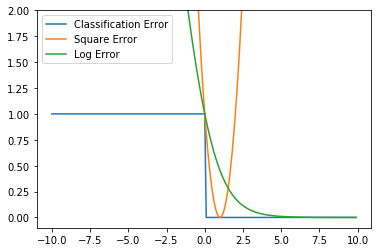

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def tanh(s):
    a = np.exp(s) - np.exp(-s)
    b = np.exp(s) + np.exp(-s)
    return a/b

def classification_error(s, y):
    signs = np.sign(s)
    return signs != y

def square_error(s, y):
    return (y-s)**2

def log_error(s, y):
    return np.log(1.0+np.exp(-y*s))

ss = np.arange(-10,10,0.1)
cls_err = classification_error(ss, 1)
sq_err = square_error(ss, 1)
log_err = log_error(ss, 1)/np.log(2)
plt.plot(ss, cls_err, label='Classification Error')
plt.plot(ss, sq_err, label='Square Error')
plt.plot(ss, log_err, label='Log Error')
plt.ylim(-0.1, 2)
plt.legend()
plt.show()

#### Exercise 3.10

1. (a) If $\eta = 1$, then the SGD algorithm will update the $w$ by: $w(t+1) = w(t) -\eta\nabla e_n(w)  = w(t) -\nabla e_n(w)$.

When $e_n(w) = \max(0, -y_n w^Tx_n)$, the derivative of $e_n(w)$ when $y_nw^Tx_n \gt 0$ (when the sample is correctly classified) is zero, the derivative is $-y_nx_n$ when $y_nw^Tx_n \lt 0$ (i.e. when the sample is misclassified). 

Take the derivatives into the SGD update equation, we see that's exactly PLA. 

1. (b) For logistic regression, we have $\nabla e_n(w) = \frac{-y_nx_n}{1+e^{y_nw^Tx_n}}$.
If $w$ is very large:
  * When $y_nw^Tx_n \gt 0$, $\nabla e_n(w) \approx 0$.
  * When $y_nw^Tx_n \le 0$, $\nabla e_n(w) \approx -y_nx_n$. 
  
The above results are consistent with the values used in PLA.

This is another indication that the logistic regression weights can be used as a good approximation for classification. 

#### Exercise 3,.11

Feature transformation $\Phi(x) = (1, x^2_1, x^2_2)$, a hyperplane in $\mathcal{Z}$ can be expressed as $\tilde{w}z = \tilde{w}_0 z_0 + \tilde{w}_1 z_1 + \tilde{w}_2 z_2 = \tilde{w}_0 + \tilde{w}_1 x^2_1 + \tilde{w}_2 x^2_2 = 0$. 
1. (a) $|\tilde{w}_1| x^2_1 - |\tilde{w}_1| x^2_2 = c$ : Hyperbola

1. (b) $\tilde{w}_0 + \tilde{w}_1 x^2_1= 0$: It can be two vertical lines parallel to axis of $x1$.

1. (c) Ellipse.
1. (d) No solution. For any $x_1$ and $x_2$, $\tilde{w}z \gt 0$. So we can't find $\tilde{w}$ that satisfies the condition.

#### Exercise 3.12 TODO

#### Exercise 3.13 

$\Phi_2(x) = (1, x_1, x_2, x^2_1, x_1x_2, x^2_x)$, make the corresponding $\tilde{w}$ as $\tilde{w}_0, \dots, \tilde{w}_5$, we have

1. (a) $(x_1-3)^2 + x_2 -1 =-1 -6x_1 + x_2+ x^2_1$, we choose $\tilde{w}_0 = -1$, $\tilde{w}_1 = -6$, $\tilde{w}_2 = 1$, $\tilde{w}_3 = 1$, $\tilde{w}_4 = 0$, $\tilde{w}_5 = 0$.

1. (b) $(x_1-3)^2 + (x_2-4)^2 -1 = 24 - 6x_1 -8x_2 + x^2_1 + x^2_2$ , we choose $\tilde{w}_0 = 24$, $\tilde{w}_1 = -6$, $\tilde{w}_2 = -8$, $\tilde{w}_3 = 1$, $\tilde{w}_4 = 0$, $\tilde{w}_5 = 1$

1. (c) $2(x_1-3)^2 + (x_2-4)^2 -1 = 33 - 12x_1 -8x_2 + 2x^2_1 + x^2_2$, we choose $\tilde{w}_0 = 33$, $\tilde{w}_1 = -12$, $\tilde{w}_2 = -8$, $\tilde{w}_3 = 2$, $\tilde{w}_4 = 0$, $\tilde{w}_5 = 1$

1. (d) $(x_1-3)^2 - (x_2-4)^2 -1 = -8- 6x_1 + 8x_2 + x^2_1 - x^2_2$, we choose $\tilde{w}_0 = -8$, $\tilde{w}_1 = -6$, $\tilde{w}_2 = 8$, $\tilde{w}_3 = 1$, $\tilde{w}_4 = 0$,  $\tilde{w}_5 = -1$

1. (e) $2(x_1+x_2-3)^2 + (x_1-x_2-4)^2 -1 = 33- 20x_1 - 4x_2 + 3x^2_1+ 2x_1x_2 +3x^2_2$, we choose $\tilde{w}_0 = 33$, $\tilde{w}_1 = -20$, $\tilde{w}_2 = -4$, $\tilde{w}_3 = 1$, $\tilde{w}_4 = 0$, $\tilde{w}_5 = 3$

1. (f) $2x_1 + x_2 -1$, we choose $\tilde{w}_0 = -1$, $\tilde{w}_1 = 2$, $\tilde{w}_2 = 1$, $\tilde{w}_3 = 0$, $\tilde{w}_4 = 0$, $\tilde{w}_5 = 0$.

#### Exercise 3.14 TODO

Consider the $Q$th order polynomial transform $\Phi_{Q}$ for $\mathcal{X} = \mathcal{R}^d$. The dimensionality $\tilde{d}$ of the feature space $\mathcal{Z}$ is: 

* d = 2: 
* d = 3
* d = 5
* d = 10

#### Exercise 3.15 TODO

#### Exercise 3.16

Steps of the algorithm that combines $\Phi_3$ with linear regression.

1. For each $x \in X$, apply $\Phi_3$ to obtain the matrix $Z$
1. Compute the pseudo-inverse $X^\dagger$ of the matrix $Z$
1. Return $w_{lin} = X^\dagger y$

If the dimension of data is large and the order of polynomial transformation is big, the resulting dimension in the feature space will grow in polynomial. The matrix $Z$ will be of size $N \times \tilde{d}$. The main computational cost will be spent on the calculation of the pseudo-inverse $X^\dagger$.